# ETL Script Documentation

## Overview

This script implements an ETL (Extract, Transform, Load) process that loads a dataset from a CSV file, monitors its data quality, cleans and transforms the data, and then inserts it into a MySQL database. The script is structured into various functions to handle each step of the process.


#### Task Prepration
- Created [parameters.py](parameters.py) file to combine all the parameters in one file to be used in the ETL script.
- Created [.env](.env) file to save the database crednitials in secure file.

#### Dependencies

- `pandas`: For handling and manipulating data.
    -  Used Pandas because the size of the data is small but if the we are dealing with bigdata we can use PySpark.
- `datetime`: For adding timestamps to the data.
- `sqlalchemy`: For interacting with the MySQL database.
- `parameters`: A custom module for storing the MySQL and file path configuration.

install the extra libraries byt running the next command in the terminal

In [ ]:
pip install pandas sqlalchemy

#### Database installation
- Created **docker-compose.yml** to pull MySQL image.
- Created **schema.sql** file and add in initdb to create the schema inside the db automatically when you ru compose command below

In [ ]:
docker compose up

- Downloaded MySQL workbench link below:
<br> https://dev.mysql.com/downloads/workbench/
- intialized the connection with the db credentials and accessed the db

- Warehouse Schema
<br>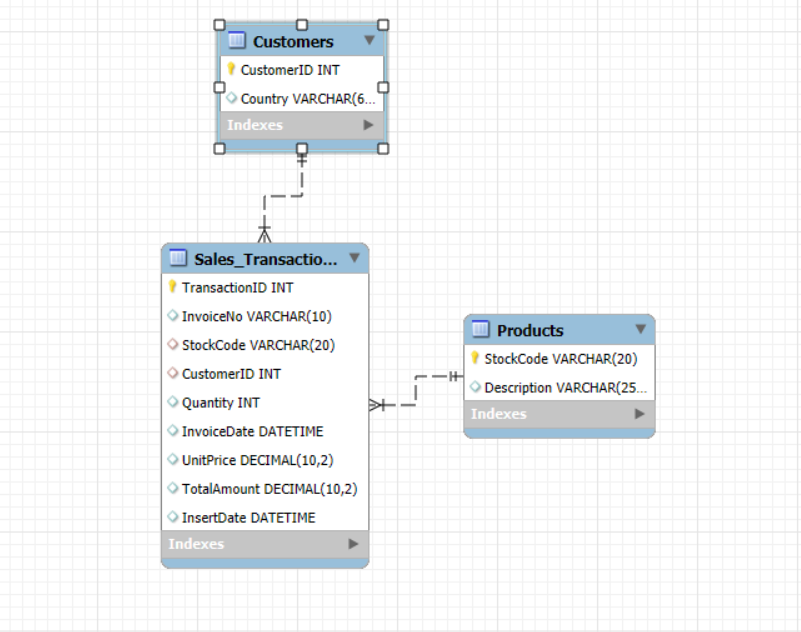

## Script Structure

### 1. **`load_data(source_path)`**
   - **Description**: Loads data from a specified CSV file into a Pandas DataFrame.
   - **Parameters**:
     - `source_path`: Path to the source CSV file.
   - **Returns**: A DataFrame containing the data, or `None` if an error occurs.

   **Exceptions Handled**:
   - `FileNotFoundError`: When the specified file is not found.
   - `pd.errors.EmptyDataError`: When the file is empty.
   - Generic exception handling for other issues during the loading process.

### 2. **`monitor_data_quality(df)`**
   - **Description**: Monitors data quality by checking for missing columns, missing values and invalid data.
   - **Parameters**:
     - `df`: The DataFrame to be checked for data quality.
   - **Returns**: A dictionary of any detected data quality issues or `None` if no issues are found.

   **Checks Performed**:
   - Missing or extra columns in the data source.
   - Missing values in the `CustomerID` column.
   - Invalid values in the `Quantity` (less than or equal to 0) and `UnitPrice` columns.

### 3. **`clean_data(df)`**
   - **Description**: Cleans the data by removing rows with missing `CustomerID`, dropping duplicates, and ensuring the `InvoiceDate` column is of `datetime` type.
   - **Parameters**:
     - `df`: The DataFrame to be cleaned.
   - **Returns**: A cleaned DataFrame, or `None` if an error occurs during cleaning.

   **Exceptions Handled**:
   - `KeyError`: When a required column is missing in the dataset.
   - Generic exception handling for other issues during data cleaning.

### 4. **`transform_data(data)`**
   - **Description**: Transforms the data by creating new columns and splitting it into separate tables (Customers, Products, Sales_Transactions).
   - **Parameters**:
     - `data`: The cleaned DataFrame.
   - **Returns**: Three DataFrames for Customers, Products, and Sales Transactions, or `None` for all if an error occurs.

   **Transformations**:
   - Adds an `InsertDate` column with the current timestamp.
   - Adds a `TotalAmount` column calculated as `Quantity * UnitPrice`.
   - Splits the data into three tables:
     - **Customers**: Contains `CustomerID`, `Country`, and `InsertDate`.
     - **Products**: Contains `StockCode`, `Description`, and `InsertDate`.
     - **Sales_Transactions**: Contains details about each transaction.

### 5. **`insert_data(table_name, table)`**
   - **Description**: Inserts the given DataFrame into a specified MySQL table.
   - **Parameters**:
     - `table_name`: Name of the MySQL table.
     - `table`: The DataFrame to insert.
   - **Returns**: None.

   **Exceptions Handled**:
   - `SQLAlchemyError`: When there's an issue inserting data into the MySQL database.
   - Generic exception handling for unexpected errors during insertion.


### 6. **`main()`**
   - **Description**: The main function orchestrates the entire ETL process.
   - **Steps**:
     1. Load the data using `load_data()`.
     2. Monitor the data quality using `monitor_data_quality()`.
     3. Clean the data using `clean_data()`.
     4. Transform the cleaned data using `transform_data()`.
     5. Insert the transformed data into the MySQL database using `insert_data()`.

### Scheduling the script
- Created [Scheduler.ps1](Scheduler.ps1) a powershell script that excute the python script.
    - and we can schedule it from Task Scheduler in the windows
    <br> ![Schema Diagram](./images/task-s.png)    
    
- Created [Scheduler.sh](Scheduler.sh) a bash version of the powershell script to Linux and MacOS users.

### Indexing
- By default MySQL create indexes for the primary keys for each table.
- But if we loaded the data without Creating the schema inside the database
    - Created a [Indexes.sql](Indexes.sql) to create 3 indexes for every Primary key in each table

### Partitioning
- Created [Partitioning.sql](Partitioning.sql) to create partitions on the fact table based on 'InvoiceDate' 
but after running the query inside the database found that it is not possible to create a partitions in a table that contains foreign keys.
- Searched for a solution and found that we can replace the references in the fact table and create a before insert triggers to do the same functionality, but didn`t implment it because the limitation of the time.
    - Created 2 queries to create 2 triggers in [trigger.sql](trigger.sql) to check if the **'CustomerID'** or **'StockCode'** does not exist in the dim tables
    - and after that we can run the partitioning query without facing any error.


### Data Versioning
- Implmented a simple versioning mechanism where I created a **'InsertDate'** column in the fact table to be able to monitor the history by quering the table and filter on the **'InsertDate'** column
##### Another implementaion that have been Implmented:
we could implment a scd type 4 where we create **Customers_History** dim to keep the old the data and in the **Customers** dim keep only the new records.
   <br> - by checking if the customer id is new if it`s new we can keep the only new records in the **Customers** dim and add the all data in the **Customers_History**.
            you can check the implemntation approach to in [Customers_scd.sql](Customers_scd.sql)

### Metadata Management
- Created [Metadatatable.sql](Metadatatable.sql) contains 2 queries to create and fill the table.
<br> ![Metadata_table](./images/metadatatable.png) 

### Performance Optimization
- Analyze query execution plans in MySQL using EXPLAIN to identify performance bottlenecks.
- Creating Indexes in the columns we are using in *WHERE* clause.
- Cache some query results that are been using frequently.
    - The query cache is deprecated as of MySQL 5.7.20, and is removed in MySQL 8.0. and I was using MySQL 8 so I created [Cache_query.sql](Cache_query.sql) file that has an example of cache a query that grouped invoices per customer ID that could be implmented in another database or MySQL previous version.


### Future Improvements
- **Partioning**: handeling the case of the foreign keys with the triggers instead of using foreign keys references which make us not able to partion the fact table. 
- **Caching**: Using different database or older version of MySQL to implment Caching.
- **Logging**: Adding proper logging instead of print statements for better error tracking and debugging.
- **Quality Monitoring**: Create schema table has every source, columns(we need), and data types Using GreatExpectations library in python that monitor the data quality.
